In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from ipywidgets import *
import numpy as np
import sys

In [2]:
import taurex.log
taurex.log.disableLogging()

In [3]:
from taurex.cache import OpacityCache,CIACache

In [4]:
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("/ca25/comp_astro_25/atmosphere/xsecs")
CIACache().set_cia_path("/ca25/comp_astro_25/atmosphere/cia/hitran")

In [5]:
from taurex.planet import Planet
planet = Planet(planet_radius=1.7420,planet_mass=1.170)

In [6]:
from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6628.0,radius=1.461)

Numba not installed, using numpy instead


In [7]:
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.25)

from taurex.chemistry import ConstantGas

h2o = ConstantGas('H2O',mix_ratio=8.349817955203785e-3)
chemistry.addGas(h2o)
co2 = ConstantGas('CO2',mix_ratio=4.295252774264071e-4)
chemistry.addGas(co2)
co = ConstantGas('CO',mix_ratio=2.888639528279619e-3)
chemistry.addGas(co)
ch4 = ConstantGas('CH4',mix_ratio=5.965544304138603e-3)
chemistry.addGas(ch4)

In [8]:
from taurex.temperature import Isothermal

isothermal = Isothermal(T=1300.0)
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution
from taurex.contributions import CIAContribution
from taurex.contributions import RayleighContribution
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())
tm.build()

In [10]:
res = tm.model()
print(res)

(array([  199.99326855,   200.00660143,   200.01993521, ...,
       33328.88933329, 33331.11125925, 33333.33333333], shape=(76744,)), array([0.01619617, 0.01620377, 0.01612921, ..., 0.01581189, 0.01581193,
       0.01581196], shape=(76744,)), array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.33431517e-009, 2.32663924e-009, 2.32892247e-009],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.25578143e-256, 1.90068202e-256, 1.60673923e-256],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.34164851e-161, 1.20372620e-161, 1.08261332e-161],
       ...,
       [8.69183210e-001, 9.58996243e-001, 9.84346839e-001, ...,
        9.96598396e-001, 9.96597389e-001, 9.96596413e-001],
       [9.21067544e-001, 9.78485336e-001, 9.92275066e-001, ...,
        9.98108007e-001, 9.98107447e-001, 9.98106904e-001],
       [9.65892245e-001, 9.90834396e-001, 9.96861571e-001, ...,
        9.99181574e-001, 9.99181331e-001, 9.99181096e-001]],


In [11]:
res

(array([  199.99326855,   200.00660143,   200.01993521, ...,
        33328.88933329, 33331.11125925, 33333.33333333], shape=(76744,)),
 array([0.01619617, 0.01620377, 0.01612921, ..., 0.01581189, 0.01581193,
        0.01581196], shape=(76744,)),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.33431517e-009, 2.32663924e-009, 2.32892247e-009],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.25578143e-256, 1.90068202e-256, 1.60673923e-256],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.34164851e-161, 1.20372620e-161, 1.08261332e-161],
        ...,
        [8.69183210e-001, 9.58996243e-001, 9.84346839e-001, ...,
         9.96598396e-001, 9.96597389e-001, 9.96596413e-001],
        [9.21067544e-001, 9.78485336e-001, 9.92275066e-001, ...,
         9.98108007e-001, 9.98107447e-001, 9.98106904e-001],
        [9.65892245e-001, 9.90834396e-001, 9.96861571e-001, ...,
         9.99181574e-001, 9.99181331e-001, 9.9

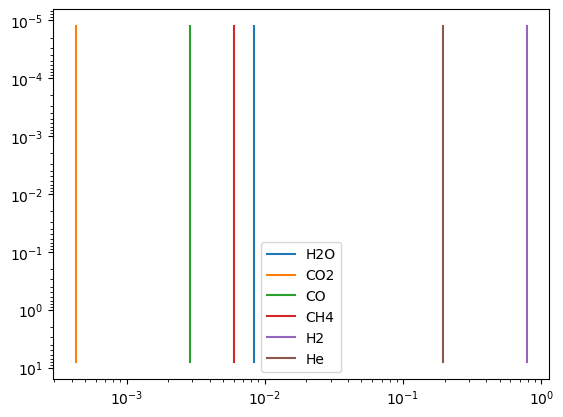

In [ ]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

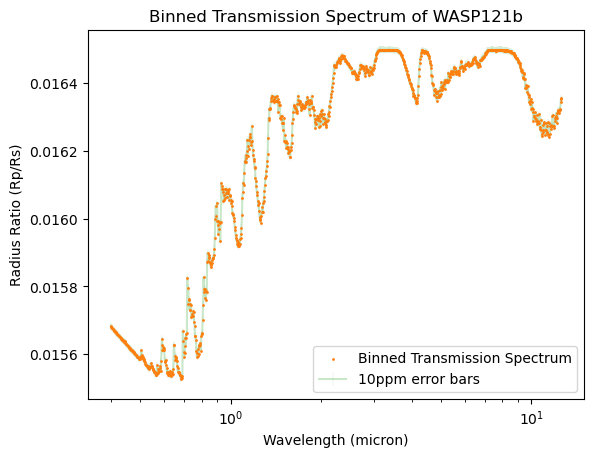

In [15]:
from taurex.binning import SimpleBinner,FluxBinner
native_grid, rprs, tau, _ = res
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))
errorbars = np.full_like(bin_rprs, 0.00001)

plt.scatter(10000/bin_wn, bin_rprs, label='Binned Transmission Spectrum', c='C1', s=1, zorder=1)
plt.errorbar(10000/bin_wn,bin_rprs, yerr=errorbars, label='10ppm error bars', c='C2', markersize=2, alpha=0.25, elinewidth=0.25, zorder=-1)
plt.xscale('log')
plt.title('Binned Transmission Spectrum of WASP121b')
plt.xlabel('Wavelength (micron)')
plt.ylabel('Radius Ratio (Rp/Rs)')
plt.legend()
plt.show()

In [16]:
Data = np.zeros((len(bin_wn),3))
Data[:,0] = 10000/bin_wn
Data[:,1] = bin_rprs
Data[:,2] = errorbars
output_df = np.savetxt('WASP121b_assignment3_taskA_spectrum.dat', Data)

In [18]:
binned_fig.savefig('WASP121b_assignment3_taskA_spectrum.png')

In [ ]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'CO2',
 'CO',
 'CH4',
 'He_H2']

In [19]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum('WASP121b_assignment3_taskA_spectrum.dat')

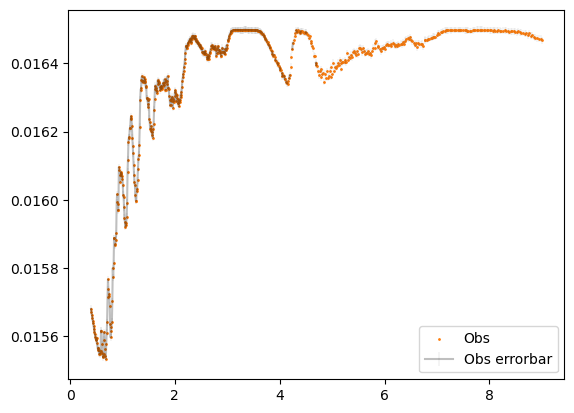

In [31]:
from taurex.data.spectrum.observed import ObservedSpectrum
import numpy as np
from taurex.binning import SimpleBinner,FluxBinner

obs = ObservedSpectrum('WASP121b_assignment3_taskA_spectrum.dat')
wngrid = np.sort(10000/np.linspace(0.3,9,1050))
bn = SimpleBinner(wngrid=wngrid)


bin_obs= bn.bindown(obs.wavenumberGrid, obs.spectrum)
errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)


plt.figure()
plt.scatter(1e4/wngrid, bin_obs[1], label='Obs', c='C1', s=1)
plt.errorbar(1e4/wngrid, bin_obs[1], yerr=errorbars[1], label='Obs errorbar',color='k',markersize=2,alpha=0.25,elinewidth=0.25)

plt.legend()
plt.show()

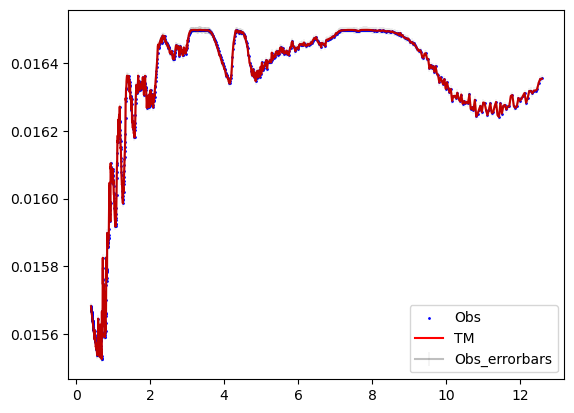

In [32]:
obin = obs.create_binner()
plt.figure()
plt.scatter(obs.wavelengthGrid, obs.spectrum, label='Obs', c='b', s=1)
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs_errorbars',c='k',markersize=2,alpha=0.25,elinewidth=0.25)
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM', c='r')
plt.legend()
plt.show()

In [36]:
from taurex.optimizer.nestle import NestleOptimizer

opt = NestleOptimizer(num_live_points=50)

#Setting up the model and observed spectrum for the optimizer
opt.set_model(tm)
opt.set_observed(obs)

#Set up which parameters to fit and their boundaries
opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.enable_fit('H2O')
# opt.enable_fit('CH4')
# opt.enable_fit('CO2')
# opt.enable_fit('CO')
opt.set_boundary('T',[900,2000])
opt.set_boundary('planet_radius',[0.9,2.3])
opt.set_boundary('H2O',[1e-8,1e-2])

In [37]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'CO2',
 'CO',
 'CH4',
 'He_H2']

In [38]:
fit_output = opt.fit()
taurex.log.disableLogging()

it=  1253 logz=10568.04948306921niter: 1254
ncall: 2526
nsamples: 1304
logz: 10568.392 +/-  0.674
h: 22.707


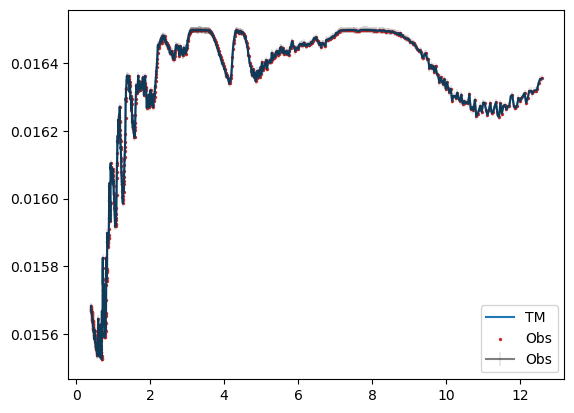

In [55]:
for fit_output,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    ax = plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs',color='k',markersize=2,alpha=0.5,elinewidth=0.25)
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.scatter(obs.wavelengthGrid, obs.spectrum, label='Obs', c='C3', s=2)
    plt.legend()
    plt.show()
ax.savefig('assignment3_taskC.png')

In [57]:
output_file = 'assignment3_taskC.txt'

# Open file to write results
with open(output_file, 'w') as f:
    # Save Input (Fixed) Parameters
    f.write("================ INPUT / FIXED PARAMETERS ================\n")
    f.write(f"Planet Mass:     {tm.planet.mass}\n")
    f.write(f"Star Temperature:{tm.star.temperature}\n")
    f.write(f"Star Radius:     {tm.star.radius}\n")
    f.write(f"Min Pressure:    {tm.pressure.profile[-1]}\n")
    f.write(f"Max Pressure:    {tm.pressure.profile[0]}\n")
    f.write(f"Num Layers:      {tm.nLayers}\n")
    f.write("\n")

    # Save Retrieved Parameters with Error Bars
    f.write("================ RETRIEVED PARAMETERS ================\n")
    f.write(f"{'Parameter':<20} {'Median':<15} {'+1sigma':<15} {'-1sigma':<15} {'Best-Fit (Map)':<15}\n")
    f.write("-" * 85 + "\n")

    # Iterate through the solution
    for sol_idx, map, median, extra in opt.get_solution():
        
        # Update model with best fit parameters for the plot later
        opt.update_model(map)

        samples = opt.get_samples(sol_idx)
        param_names = opt.fit_names

        for i, name in enumerate(param_names):
            s = samples[:, i]
            
            # Calculate 16th, 50th (Median), and 84th percentiles
            q16, q50, q84 = np.percentile(s, [16, 50, 84])
            
            sigma_plus = q84 - q50
            sigma_minus = q50 - q16
            best_fit_val = median[i]

            # Write formatted line to file
            f.write(f"{name:<20} {q50:<15.5e} {sigma_plus:<15.5e} {sigma_minus:<15.5e} {best_fit_val:<15.5e}\n")

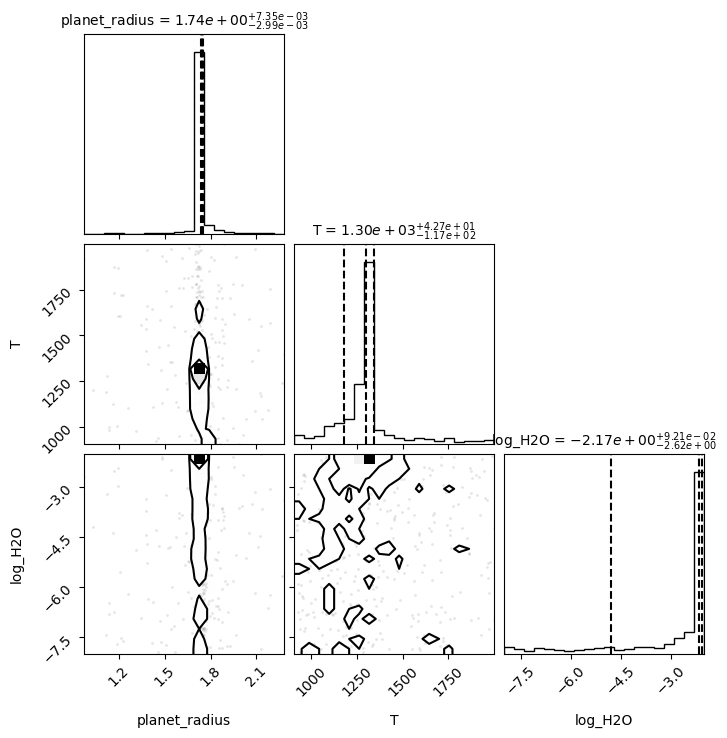

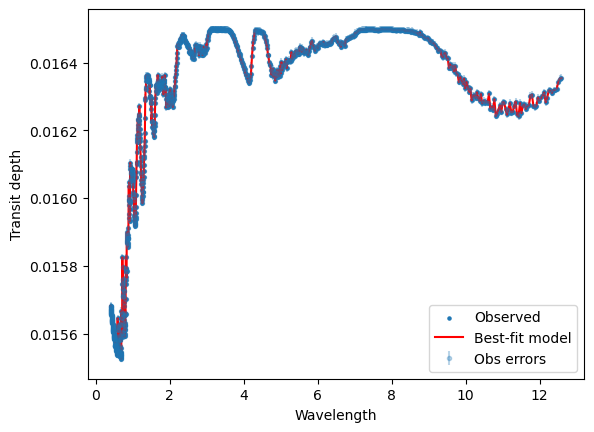

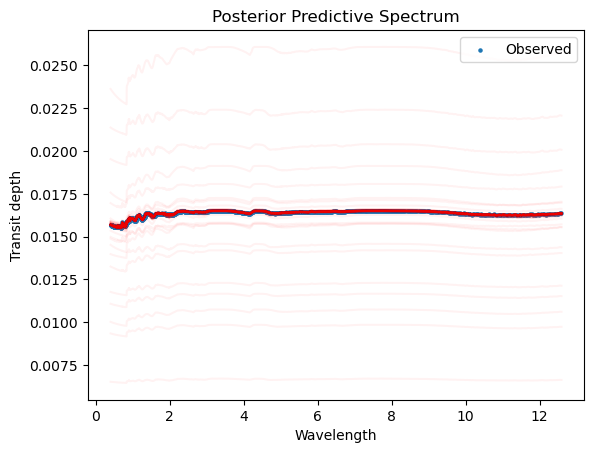

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# =======================
# GET POSTERIOR SAMPLES
# =======================
solution_idx = 0
samples = opt.get_samples(solution_idx)
param_names = opt.fit_names

# =======================
# CORNER PLOT
# =======================
fig_corner = corner.corner(
    samples,
    labels=param_names,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2e",
    title_kwargs={"fontsize": 10}
)

fig_corner.savefig("Assignment3_taskC_posteriors_corner.png")
plt.show()

# =======================
# BEST-FIT MODEL PLOT
# =======================
# Use MAP solution
for sol_idx, map_params, median, _ in opt.get_solution():
    opt.update_model(map_params)

model_spec = tm.model(obs.wavenumberGrid)
binned_model = obin.bin_model(model_spec)[1]

plt.figure()
plt.scatter(obs.wavelengthGrid, obs.spectrum, s=5, label="Observed")
plt.errorbar(
    obs.wavelengthGrid,
    obs.spectrum,
    obs.errorBar,
    fmt='.',
    alpha=0.3,
    label="Obs errors"
)
plt.plot(obs.wavelengthGrid, binned_model, 'r', label="Best-fit model")
plt.xlabel("Wavelength")
plt.ylabel("Transit depth")
plt.legend()
plt.savefig("Assignment3_taskC.png")
plt.show()

# =======================
# POSTERIOR PREDICTIVE PLOT
# =======================
n_draws = 100
draw_idx = np.random.choice(samples.shape[0], n_draws, replace=False)

plt.figure()
plt.scatter(obs.wavelengthGrid, obs.spectrum, s=5, label="Observed")

for i in draw_idx:
    opt.update_model(samples[i])
    model = tm.model(obs.wavenumberGrid)
    binned = obin.bin_model(model)[1]
    plt.plot(obs.wavelengthGrid, binned, color='red', alpha=0.05)

plt.xlabel("Wavelength")
plt.ylabel("Transit depth")
plt.title("Posterior Predictive Spectrum")
plt.legend()
plt.savefig("Assignment3_taskC_posterior_predictive.png")
plt.show()
